Lab 0

In [1]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from torchvision import transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import tensorflow


In [2]:
# Download datasets

BATCH_SIZE = 64
BATCH_SIZE_ALEX = 32

transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

transformer_alexnet = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

transforms_mnist = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transforms_svhn = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformer)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transformer)

trainset_alexnet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformer_alexnet)
test_set_alexnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transformer_alexnet)

# Load MNIST dataset
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=True, transform=transforms_mnist)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=True, transform=transforms_mnist)

# Load SVHN dataset
svhn_trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                          download=True, transform=transforms_svhn)
svhn_testset = torchvision.datasets.SVHN(root='./data', split='test',
                                         download=True, transform=transforms_svhn)


total_size = len(trainset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size

train_set, valid_set = random_split(trainset, [train_size, valid_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

train_set_alexnet, valid_set_alexnet = random_split(trainset_alexnet, [train_size, valid_size])
train_loader_alexnet = torch.utils.data.DataLoader(train_set_alexnet, batch_size=BATCH_SIZE_ALEX, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(valid_set_alexnet, batch_size=BATCH_SIZE_ALEX, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_set_alexnet, batch_size=BATCH_SIZE_ALEX, shuffle=False)


total_size = len(mnist_trainset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size


mnist_train_set, mnist_valid_set = random_split(mnist_trainset, [train_size, valid_size])
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

total_size = len(svhn_trainset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size

svhn_train_set, svhn_valid_set = random_split(svhn_trainset, [train_size, valid_size])
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_set, batch_size=BATCH_SIZE, shuffle=True)
svhn_valid_loader = torch.utils.data.DataLoader(svhn_valid_set, batch_size=BATCH_SIZE, shuffle=True)
svhn_test_loader = torch.utils.data.DataLoader(svhn_testset, batch_size=BATCH_SIZE, shuffle=False)



100%|██████████| 170498071/170498071 [00:06<00:00, 27951230.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:00<00:00, 270883303.87it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40164354.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66859611.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4424182.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182040794/182040794 [00:42<00:00, 4287167.69it/s]


100%|██████████| 64275384/64275384 [00:23<00:00, 2744567.56it/s]


In [3]:
# CNN model 1
class CNN1(torch.nn.Module):
    def __init__(self, inputs):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=inputs, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)
        self.lr = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.lr(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.lr(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = self.lr(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN2(torch.nn.Module):
    def __init__(self,inputs):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=inputs, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.tanh(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN3(torch.nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# train model
def train(model, optimizer, criterion, train_loader, valid_loader, num_epochs,device):
    global writer
    train_loss_list = []
    valid_loss_list = []
    best_val_loss = np.inf
    best_model_sd = None
    model.to(device)
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0

        model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader)

        model.eval()

        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

        valid_loss = valid_loss / len(valid_loader)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_model_sd = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_sd)

    plt.plot(range(1,num_epochs + 1), train_loss_list)
    plt.plot(range(1,num_epochs + 1), valid_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")

    return model


In [17]:
def test_model(model, test_loader,device):
    global writer
    classes = ['plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test accuracy of the network: {100 * correct // total} %')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [6]:
LEARNING_RATE = 0.0001
epochs = 50

Epoch 0/50, Training Loss: 147.4543, Validation Loss: 146.8252
Epoch 10/50, Training Loss: 142.7031, Validation Loss: 142.0091
Epoch 20/50, Training Loss: 136.0766, Validation Loss: 135.2417
Epoch 30/50, Training Loss: 129.6268, Validation Loss: 128.7733
Epoch 40/50, Training Loss: 124.8648, Validation Loss: 124.0212
Test accuracy of the network: 35 %


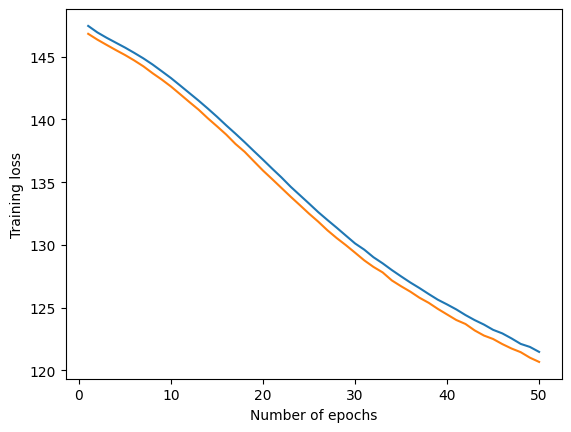

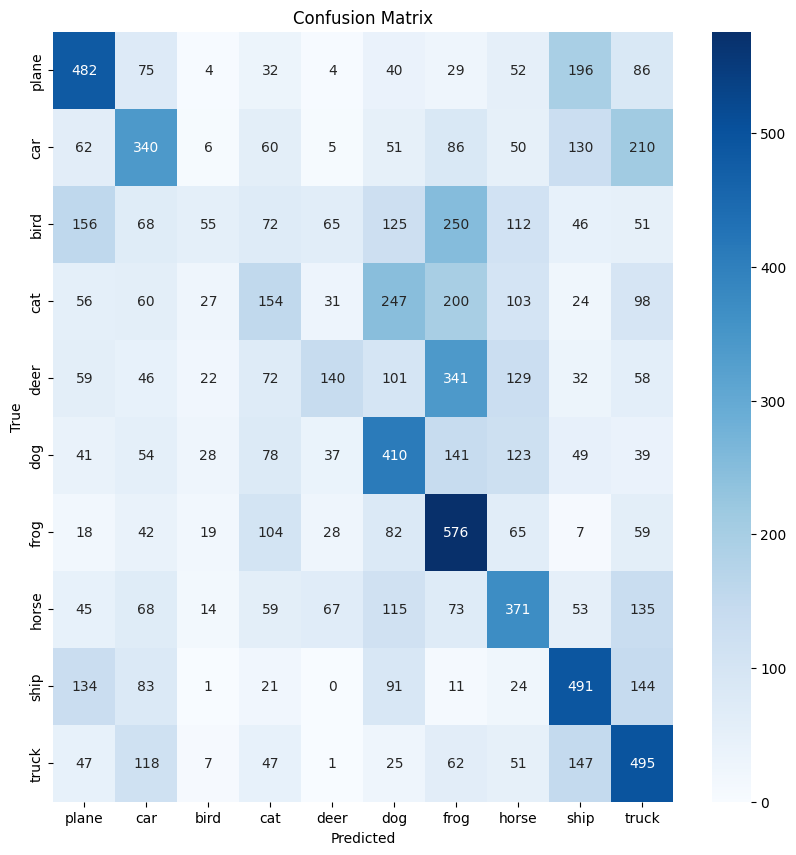

In [ ]:
model = CNN1(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)

trained_model = train(model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=train_loader,valid_loader=valid_loader)

test_model(model=trained_model,test_loader=test_loader)

Epoch 0/50, Training Loss: 111.9997, Validation Loss: 96.3462
Epoch 10/50, Training Loss: 63.9971, Validation Loss: 66.1828
Epoch 20/50, Training Loss: 54.4672, Validation Loss: 59.4991
Epoch 30/50, Training Loss: 48.2160, Validation Loss: 57.3296
Epoch 40/50, Training Loss: 43.2951, Validation Loss: 55.5893
Test accuracy of the network: 72 %


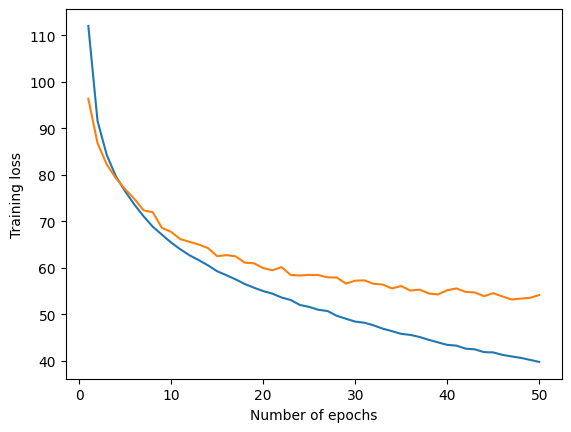

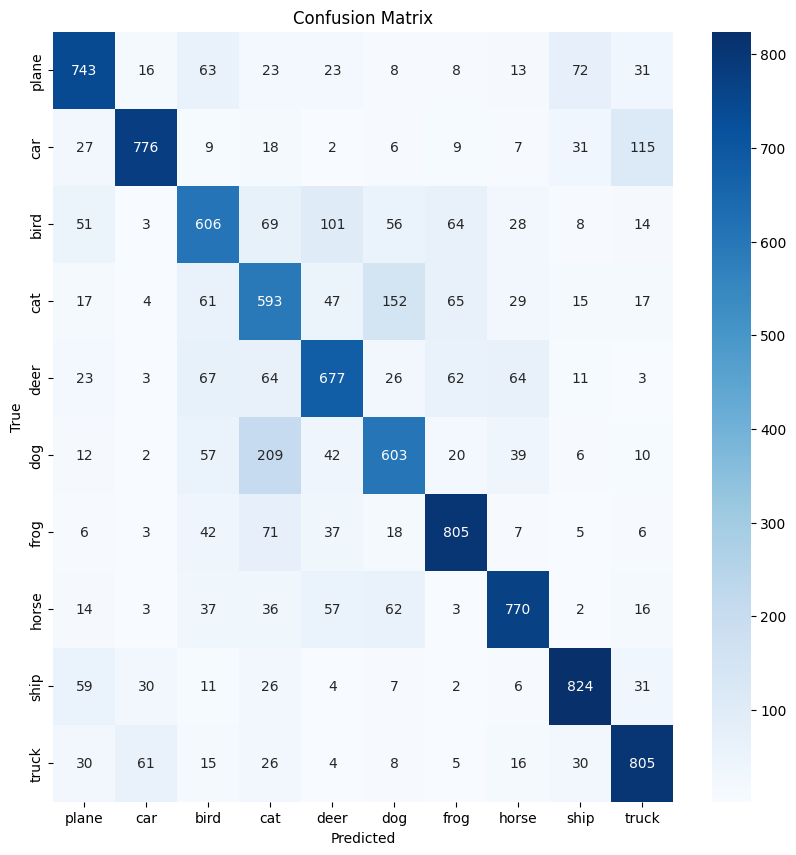

In [ ]:
model = CNN1(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

trained_model = train(model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=train_loader,valid_loader=valid_loader)

test_model(model=trained_model,test_loader=test_loader)

Epoch 0/50, Training Loss: 111.2166, Validation Loss: 98.7685
Epoch 10/50, Training Loss: 61.5342, Validation Loss: 65.6883
Epoch 20/50, Training Loss: 51.9613, Validation Loss: 58.6163
Epoch 30/50, Training Loss: 46.3031, Validation Loss: 56.1606
Epoch 40/50, Training Loss: 41.8737, Validation Loss: 54.5553
Test accuracy of the network: 71 %


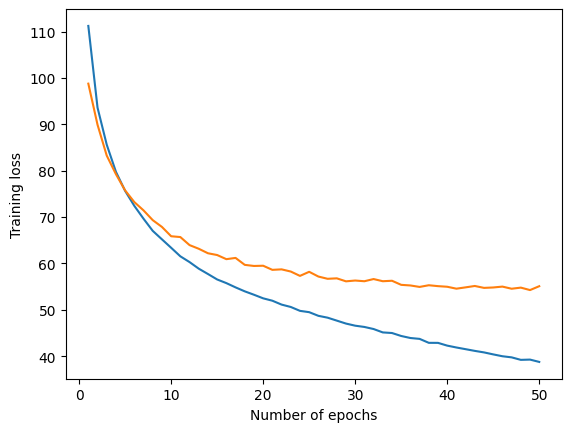

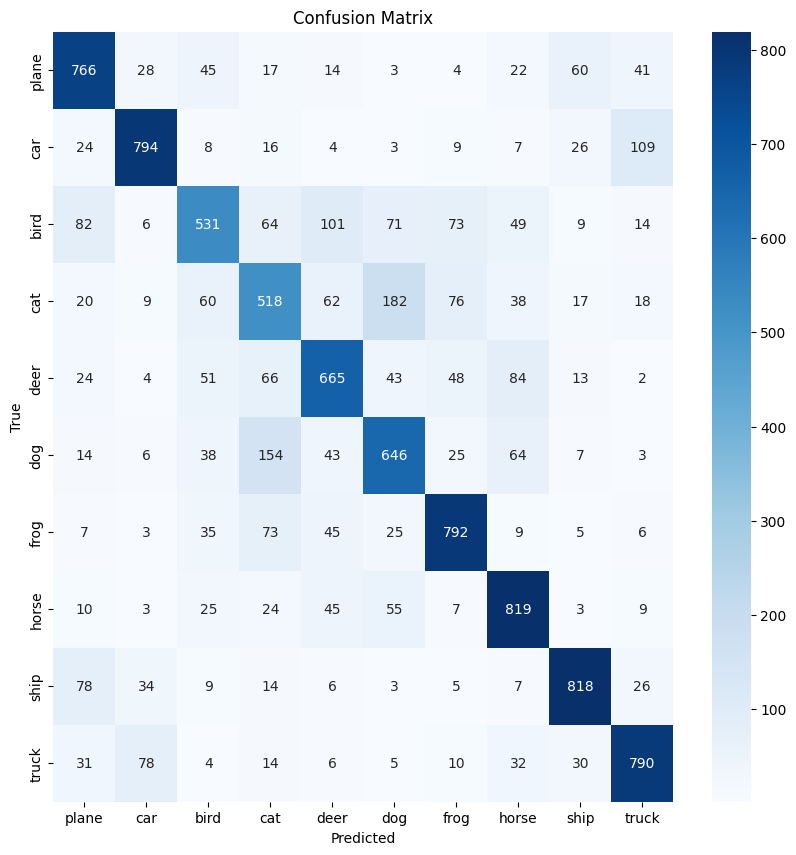

In [ ]:
model = CNN2(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

trained_model = train(model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=train_loader,valid_loader=valid_loader)

test_model(model=trained_model,test_loader=test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/50, Training Loss: 73.6680, Validation Loss: 73.6439
Epoch 10/50, Training Loss: 73.6658, Validation Loss: 73.6476
Epoch 20/50, Training Loss: 73.6658, Validation Loss: 73.6483
Epoch 30/50, Training Loss: 73.6658, Validation Loss: 73.6486
Epoch 40/50, Training Loss: 73.6657, Validation Loss: 73.6485


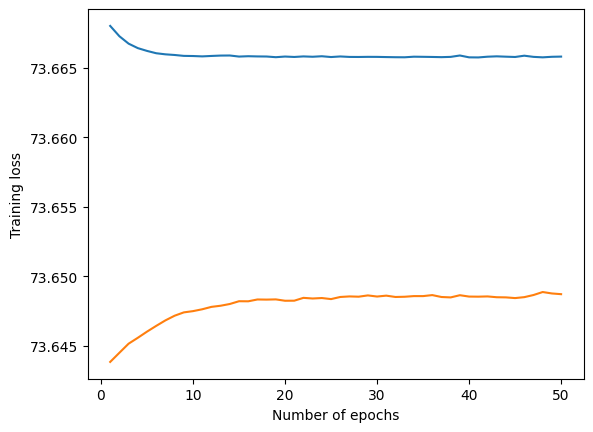

In [8]:
LEARNING_RATE_ALEX = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_model = torchvision.models.alexnet(pretrained=False)
alex_model = model.to(device)
num_ftrs = alex_model.classifier[6].in_features
alex_model.classifier[6] = nn.Linear(num_ftrs, 10)
alex_model.classifier[6].requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_model.parameters(),lr=LEARNING_RATE)
trained_alex_model = train(alex_model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=train_loader_alexnet,valid_loader=valid_loader_alexnet,device=device)


Test accuracy of the network: 10 %


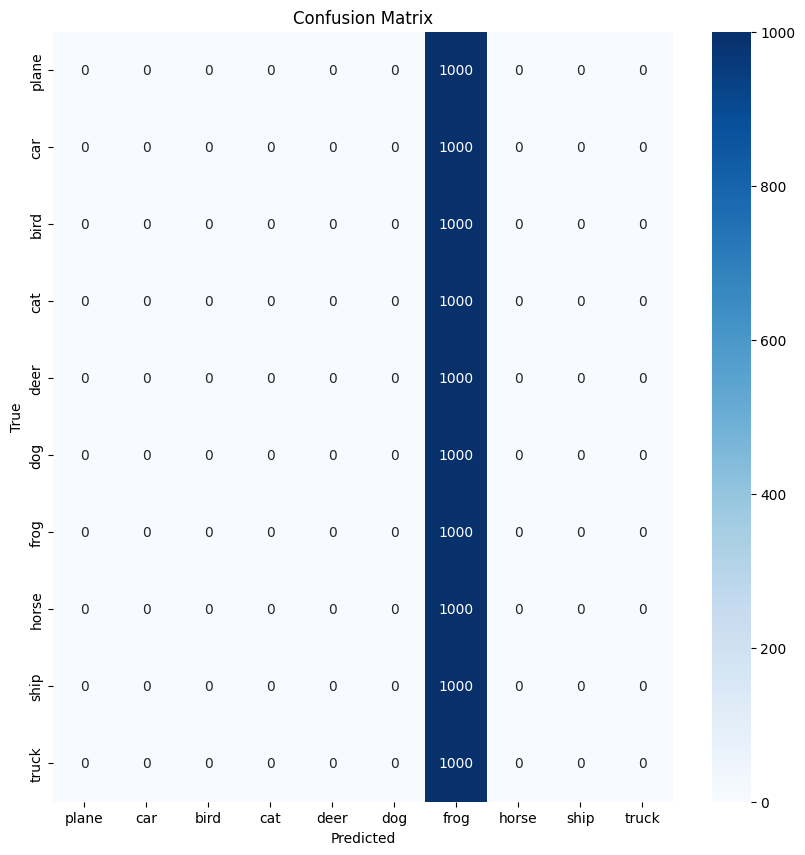

In [18]:
test_model(model=trained_alex_model,test_loader=test_loader_alexnet,device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/50, Training Loss: 20.8591, Validation Loss: 14.7678
Epoch 10/50, Training Loss: 4.2610, Validation Loss: 10.3282
Epoch 20/50, Training Loss: 2.7086, Validation Loss: 11.1807
Epoch 30/50, Training Loss: 2.2170, Validation Loss: 14.4550
Epoch 40/50, Training Loss: 1.6315, Validation Loss: 12.6953


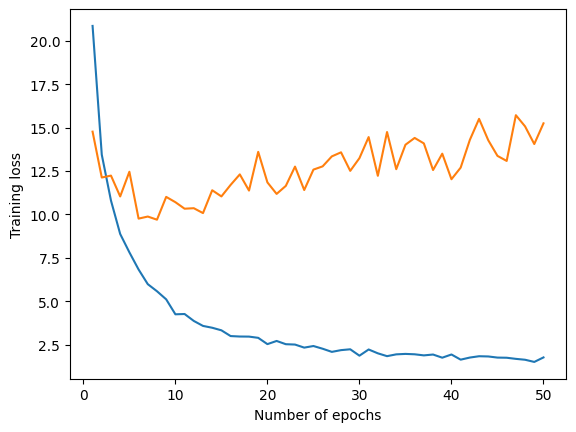

In [12]:
alex_pretrained_model = torchvision.models.alexnet(pretrained=True)
alex_pretrained_model = alex_pretrained_model.to(device)
num_ftrs = model.classifier[6].in_features
alex_pretrained_model.classifier[6] = nn.Linear(num_ftrs, 10)
alex_pretrained_model.classifier[6].requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_pretrained_model.parameters(),lr=LEARNING_RATE)

alex_trained_model = train(alex_pretrained_model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=train_loader_alexnet,valid_loader=valid_loader_alexnet,device=device)

Test accuracy of the network: 89 %


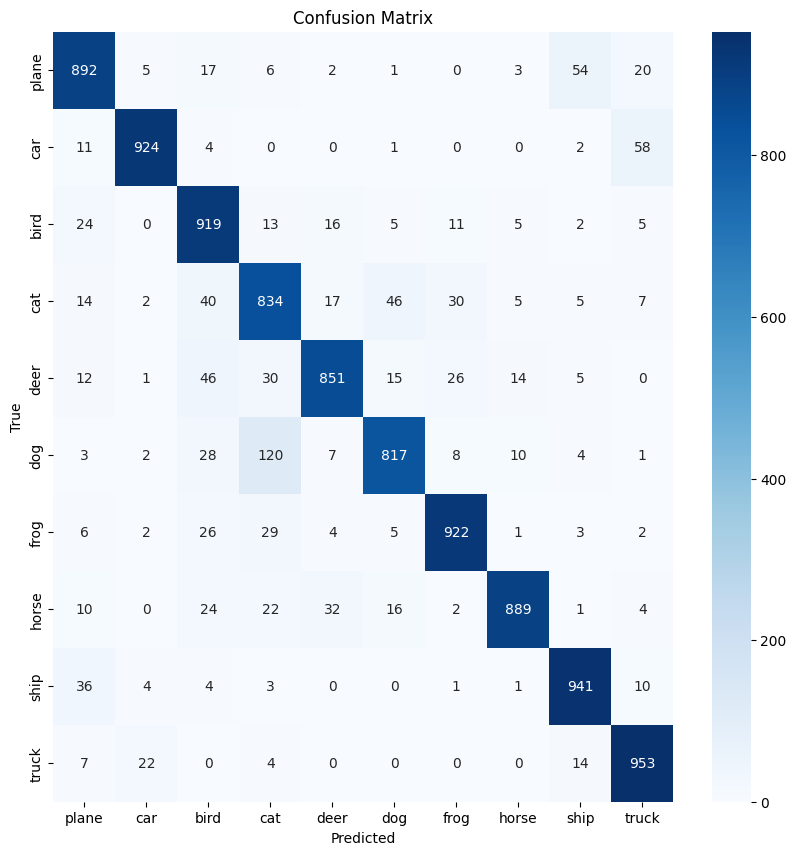

In [19]:
test_model(model=alex_trained_model,test_loader=test_loader_alexnet,device=device)

Epoch 0/50, Training Loss: 34.1808, Validation Loss: 12.1154
Epoch 10/50, Training Loss: 1.9284, Validation Loss: 2.9461
Epoch 20/50, Training Loss: 0.7376, Validation Loss: 3.0441
Epoch 30/50, Training Loss: 0.2554, Validation Loss: 3.0550
Epoch 40/50, Training Loss: 0.0707, Validation Loss: 3.5934


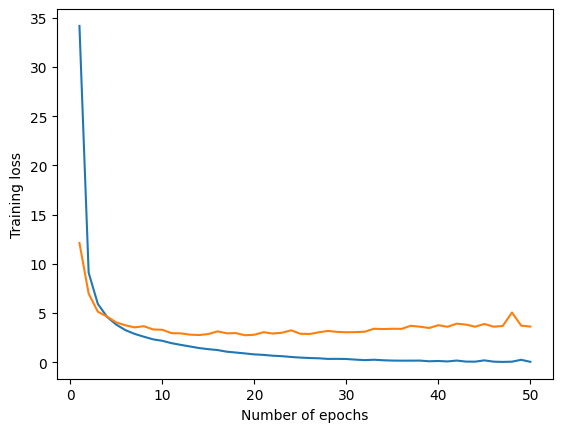

In [ ]:
mnist_model = CNN3()
mnist_model = mnist_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters(),lr=LEARNING_RATE)

trained_model_mnist = train(mnist_model,optimizer=optimizer,criterion=criterion,num_epochs=epochs,train_loader=mnist_train_loader,valid_loader=mnist_valid_loader)

Test accuracy of the network: 98 %


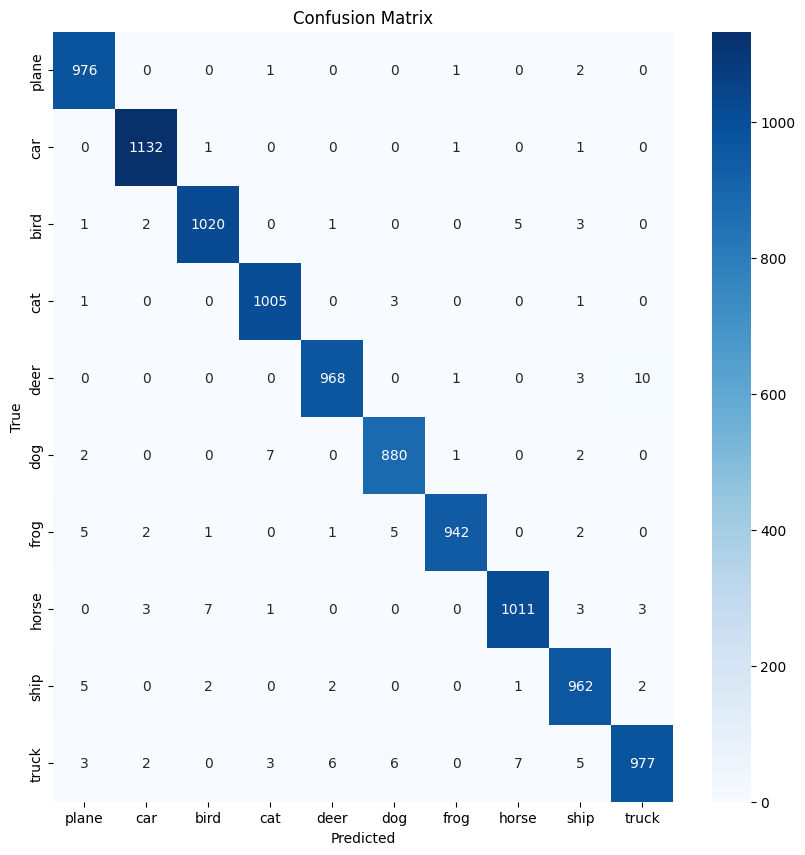

In [ ]:
test_model(model=trained_model_mnist,test_loader=mnist_test_loader)

Test accuracy of the network: 23 %


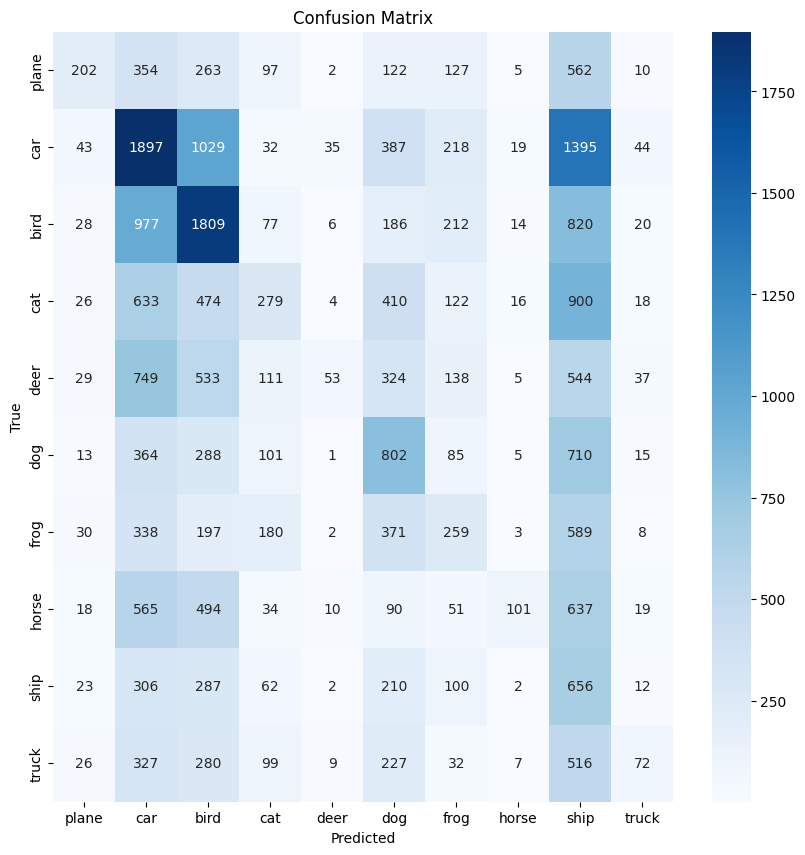

In [ ]:
test_model(model=trained_model_mnist,test_loader=svhn_test_loader)